In [1]:
!nvidia-smi

Sun Jan 29 10:23:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from importlib import import_module
from keras.api._v2 import keras as KerasAPI
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

keras: KerasAPI = import_module('tensorflow.keras')

In [5]:
# load cats and dogs dataset
(cvd_train, cvd_val, cvd_test)  = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
                                            as_supervised=True, shuffle_files=False, data_dir='/content/drive/MyDrive/tensorflow_ds')

In [ ]:
cvd_train.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
isinstance(cvd_train, tf.data.Dataset)

True

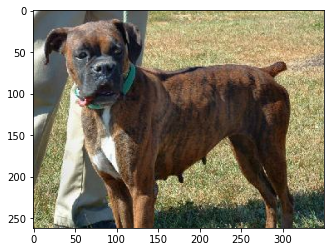

In [6]:
for element in cvd_train:
    plt.imshow(element[0])
    break

In [ ]:
train_images = cvd_train.map(lambda image, label: image)
train_labels = cvd_train.map(lambda image, label: 1 - label)

train_images, train_labels

(<MapDataset element_spec=TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None)>,
 <MapDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>)

In [7]:
image_size = 224
auto = tf.data.experimental.AUTOTUNE

data_augmentation = keras.Sequential(
                    [
                        keras.layers.RandomFlip('horizontal_and_vertical'),
                        keras.layers.RandomRotation(0.2),
                    ],
                        name='data_augmentation')

def make_dataset(images, labels, is_train=False):
    dataset = tf.data.Dataset.zip((images, labels))
    dataset = dataset.map(lambda x, y: (tf.image.resize(x, (image_size, image_size)), y), num_parallel_calls=auto)
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=auto)
    dataset = dataset.map(lambda x, y: (x / 255.0, y), num_parallel_calls=auto)
    if is_train:
        dataset = dataset.shuffle(320)
        
    dataset = dataset.batch(32)

    if is_train:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto)
    
    return dataset.prefetch(auto)

In [ ]:
train_dataset = make_dataset(train_images, train_labels, is_train=True)

In [ ]:
val_dataset = make_dataset(cvd_val.map(lambda image, label: image), cvd_val.map(lambda image, label: 1 - label))

In [ ]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

tf.Tensor(0, shape=(), dtype=int64)


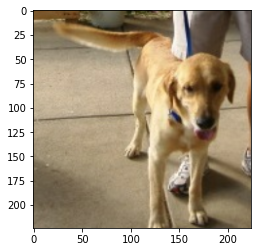

tf.Tensor(1, shape=(), dtype=int64)


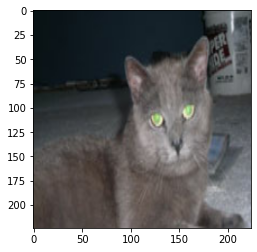

tf.Tensor(1, shape=(), dtype=int64)


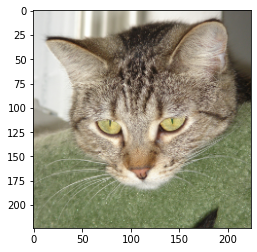

tf.Tensor(0, shape=(), dtype=int64)


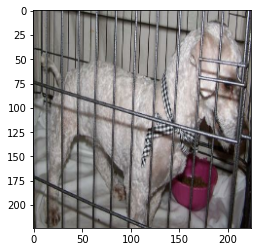

tf.Tensor(1, shape=(), dtype=int64)


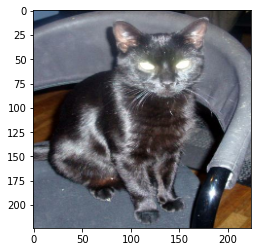

tf.Tensor(0, shape=(), dtype=int64)


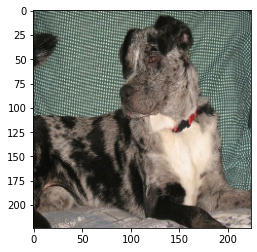

In [9]:
i = 0
for element, label in val_dataset:
    print(label[0])
    plt.imshow(element[0])
    plt.show()
    i += 1
    if i > 5:
      break

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/mobile_v2.h5', save_best_only=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(min_delta=0.005, patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, min_delta=0.005, min_lr=1e-8, patience=3)

In [ ]:
mobile_v2 = keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, classes=1, classifier_activation='sigmoid')
mobile_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
mobile_v2.trainable = False

In [ ]:
mobile_net_v2 = keras.models.Sequential(mobile_v2)
mobile_net_v2.add(keras.layers.AveragePooling2D(pool_size=(7, 7)))
mobile_net_v2.add(keras.layers.Flatten())
mobile_net_v2.add(keras.layers.Dense(1024, kernel_initializer='lecun_normal', activation='selu'))
mobile_net_v2.add(keras.layers.Dense(1024, kernel_initializer='lecun_normal', activation='selu'))
mobile_net_v2.add(keras.layers.Dense(1, activation='sigmoid'))
mobile_net_v2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_2 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 1)                

In [ ]:
nadam_optimizer = keras.optimizers.Nadam(learning_rate=1e-4)
mobile_net_v2.compile(loss='binary_crossentropy', optimizer=nadam_optimizer, metrics=['accuracy'])

In [ ]:
mobile_net_v2.fit(train_dataset, 
                  epochs=100, 
                  batch_size=32,
                  validation_data=val_dataset,
                  callbacks=[checkpoint_cb, lr_scheduler, early_stopping])


Epoch 1/100
582/582 [==============================] - 125s 209ms/step - loss: 0.1422 - accuracy: 0.9420 - val_loss: 0.0985 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 2/100
582/582 [==============================] - 123s 209ms/step - loss: 0.1329 - accuracy: 0.9436 - val_loss: 0.0562 - val_accuracy: 0.9781 - lr: 1.0000e-04
Epoch 3/100
582/582 [==============================] - 121s 207ms/step - loss: 0.1238 - accuracy: 0.9509 - val_loss: 0.0574 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 4/100
582/582 [==============================] - 121s 207ms/step - loss: 0.1162 - accuracy: 0.9524 - val_loss: 0.0638 - val_accuracy: 0.9772 - lr: 1.0000e-04
Epoch 5/100
582/582 [==============================] - 121s 206ms/step - loss: 0.1113 - accuracy: 0.9555 - val_loss: 0.0611 - val_accuracy: 0.9772 - lr: 1.0000e-04
Epoch 6/100
582/582 [==============================] - 121s 206ms/step - loss: 0.0950 - accuracy: 0.9629 - val_loss: 0.0586 - val_accuracy: 0.9781 - lr: 1.0000e-05
Epoch 7/100
582/

In [10]:
test_data = make_dataset(cvd_test.map(lambda image, label: image), 
                         cvd_test.map(lambda image, label: 1 - label))
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [11]:
test_images = test_data.map(lambda image, label: image)
test_labels = test_data.map(lambda image, label: label)

In [13]:
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(y_pred: np.array, y_test: np.array, threshold_proba=0.5) -> None:
    '''Plots the confusion matrix, ROC curve and the precision-recall curve.
    
        ### Parameters:
            y_pred: The predicted values (proba)
            y_test: The true values
        ### Returns: 
            None'''

    y_pred_hard = y_pred > threshold_proba
    print(classification_report(y_test, y_pred_hard))
    cm = confusion_matrix(y_test, y_pred_hard)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True)
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    line_threshold = [thresholds for thresholds in thresholds if thresholds >= threshold_proba][-1]
    idx = np.argwhere(thresholds == line_threshold)[0][0]
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot(fpr[idx], tpr[idx], "rx")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    line_threshold = [thresholds for thresholds in thresholds if thresholds >= threshold_proba][0]
    idx = np.argwhere(thresholds == line_threshold)[0][0]
    plt.plot(recall, precision, linewidth=2, label=None)
    plt.plot(recall[idx], precision[idx], "rx")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall', fontsize=10)
    plt.ylabel('Precision', fontsize=10)
    plt.show()

    def plot_aux_lines():
        plt.plot([line_threshold, line_threshold], [0., precision[idx]], "r:")
        plt.plot([line_threshold, line_threshold], [0., recall[idx]], "r:")
        plt.plot([0.0, line_threshold], [recall[idx], recall[idx]], "r:")

        plt.plot([line_threshold], [recall[idx]], "gx")
        plt.plot([line_threshold], [precision[idx]], "bx")
        
        plt.text(line_threshold + 0.03, precision[idx], f'{precision[idx]:.2f}', fontsize=10, color="b")
        plt.text(line_threshold + 0.03, recall[idx], f'{recall[idx]:.2f}', fontsize=10, color="g")
    
    plt.plot(thresholds, precision[:-1], "b-", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")

    plot_aux_lines()
    
    plt.xlabel("Threshold", fontsize=10)
    plt.legend(loc="upper right", fontsize=10)
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()

In [14]:
y_pred = mobile_net_v2.predict(test_images)
y_pred

73/73 [==============================] - 13s 73ms/step


array([[9.9998069e-01],
       [3.3497673e-01],
       [3.6385546e-03],
       ...,
       [9.9996591e-01],
       [3.5475040e-04],
       [9.9999225e-01]], dtype=float32)

In [15]:
y_pred.shape

(2326, 1)

In [16]:
test_labels = test_labels.unbatch()

In [17]:
test_lab_np = np.stack(list(test_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1166
           1       0.99      0.98      0.98      1160

    accuracy                           0.98      2326
   macro avg       0.98      0.98      0.98      2326
weighted avg       0.98      0.98      0.98      2326



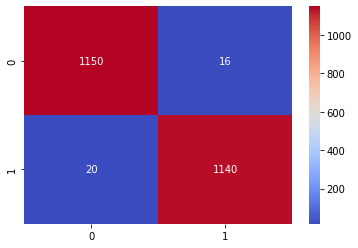

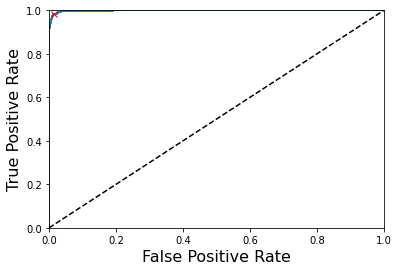

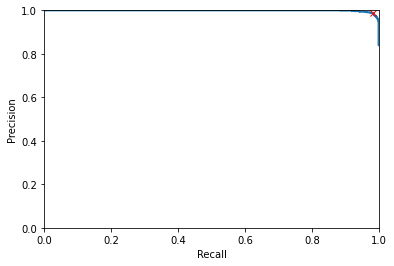

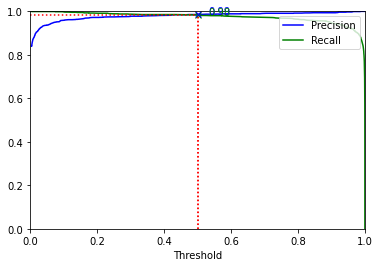

In [18]:
plot_metrics(y_pred, test_lab_np)